In [145]:
import pandas as pd
import numpy as np

from ggplot import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [146]:
train_features = pd.read_csv('indeed_data_science_exercise/train_features_2013-03-07.csv')
train_salaries = pd.read_csv('indeed_data_science_exercise/train_salaries_2013-03-07.csv')
test_features = pd.read_csv('indeed_data_science_exercise/test_features_2013-03-07.csv')

In [147]:
train = train_features.join(train_salaries.set_index('jobId'), on='jobId')

# EDA

Let's first check whether the dimension of joined training data match original data:

In [148]:
train.shape, train_features.shape, train_salaries.shape

((1000000, 9), (1000000, 8), (1000000, 2))

In [149]:
test_features.shape

(1000000, 8)

In [150]:
train.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [151]:
print(train.info(), train.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
salary                 1000000 non-null int64
dtypes: int64(3), object(6)
memory usage: 68.7+ MB
None jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64


In [152]:
print(train.describe())

       yearsExperience  milesFromMetropolis          salary
count   1000000.000000       1000000.000000  1000000.000000
mean         11.992386            49.529260      116.061818
std           7.212391            28.877733       38.717936
min           0.000000             0.000000        0.000000
25%           6.000000            25.000000       88.000000
50%          12.000000            50.000000      114.000000
75%          18.000000            75.000000      141.000000
max          24.000000            99.000000      301.000000


Here is the distribution of $salary$:

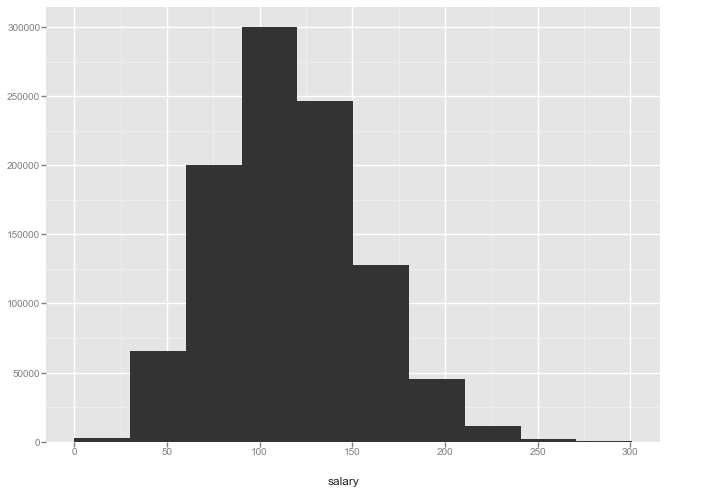

<ggplot: (345687679)>

In [153]:
ggplot(train, aes(x = 'salary'))+ geom_histogram()

There seems to be some unnormal values:

In [154]:
train[train['salary']<=10]
# None if these make sense, no on will have 0 salary, let alone CTO/Dotoral...

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


In [155]:
train[train['salary']>=290]
# all CEO/CTO/CFO, high salary make sense 

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
47203,JOB1362684454890,COMP18,CEO,BACHELORS,BUSINESS,FINANCE,22,18,292
293221,JOB1362684700908,COMP44,CEO,DOCTORAL,ENGINEERING,OIL,19,18,294
377196,JOB1362684784883,COMP5,CEO,DOCTORAL,ENGINEERING,WEB,20,8,290
400611,JOB1362684808298,COMP45,CFO,DOCTORAL,ENGINEERING,OIL,23,3,301
503962,JOB1362684911649,COMP3,CEO,DOCTORAL,PHYSICS,OIL,24,1,293
572777,JOB1362684980464,COMP60,CEO,MASTERS,ENGINEERING,OIL,22,1,298
685562,JOB1362685093249,COMP47,CTO,MASTERS,ENGINEERING,OIL,24,0,301
884902,JOB1362685292589,COMP1,CTO,MASTERS,BUSINESS,FINANCE,24,2,292
905713,JOB1362685313400,COMP35,CEO,DOCTORAL,BUSINESS,FINANCE,16,17,293
911747,JOB1362685319434,COMP3,CEO,BACHELORS,BUSINESS,FINANCE,24,28,294


So let's clean the data to be:

In [156]:
train = train[train['salary']!=0]

Let's then look at the unique value counts of each categorical variables and distribution of numerical vairables:

Text(0.5,1,'companyId Value Counts')

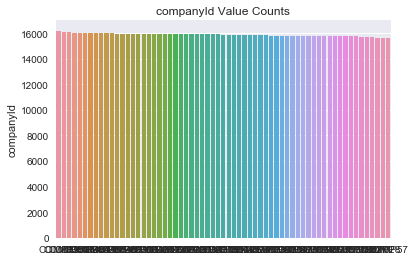

In [157]:
companyId_value_counts = train.companyId.value_counts() 
sns.barplot(x=companyId_value_counts.index, y=companyId_value_counts).set_title('companyId Value Counts')
# evenly distributed 

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

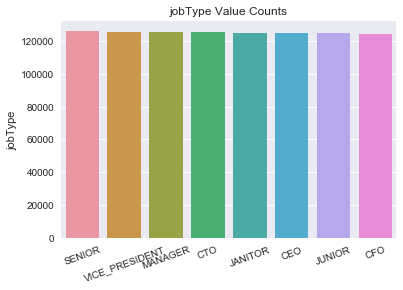

In [158]:
jobType_value_counts = train.jobType.value_counts() 
sns.barplot(x=jobType_value_counts.index, y=jobType_value_counts).set_title('jobType Value Counts')
plt.xticks(rotation=20)
# eveny distributed... but how can the number of CXO = number of JUNIOR
# So maybe the data was intentionally drew from each job type evenly 

Text(0.5,1,'degree Value Counts')

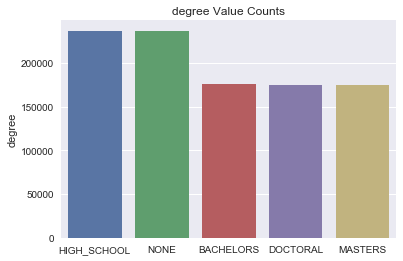

In [159]:
degree_value_counts = train.degree.value_counts() 
sns.barplot(x=degree_value_counts.index, y=degree_value_counts).set_title('degree Value Counts')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

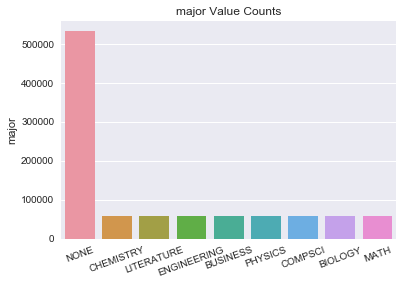

In [160]:
major_value_counts = train.major.value_counts() 
sns.barplot(x=major_value_counts.index, y=major_value_counts).set_title('major Value Counts')
plt.xticks(rotation=20)
# most of the majors are unknown

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

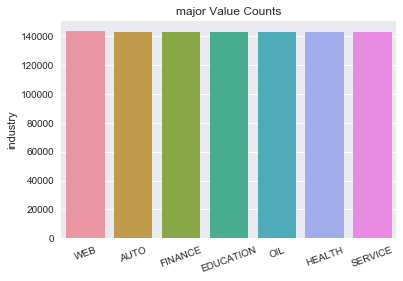

In [161]:
industry_value_counts = train.industry.value_counts() 
sns.barplot(x=industry_value_counts.index, y=industry_value_counts).set_title('major Value Counts')
plt.xticks(rotation=20)
# evenly distributed 

/Users/SONGZIZHEN/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


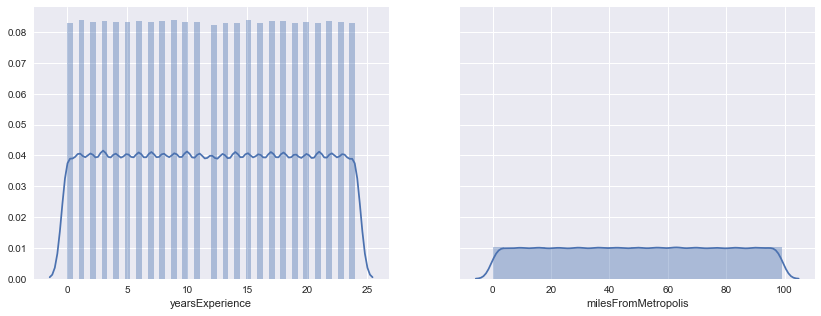

In [162]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 5), sharey=True)
sns.set(color_codes=True)
sns.distplot(train.yearsExperience, ax = ax1)
sns.distplot(train.milesFromMetropolis, ax = ax2)

Both numerical variables are discrete and evenly distributed.  
Most of the categorical variables are also eveny distributed, even jobType.  
So I inspect that **this data is either extracted intentionally for each feature evenly, or generated fake data**.


Let's look at the distribution of salary and the distribution of salary over explanatory Variables:

/Users/SONGZIZHEN/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


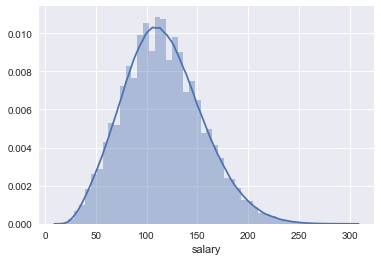

In [163]:
sns.set(color_codes=True)
sns.distplot(train["salary"])

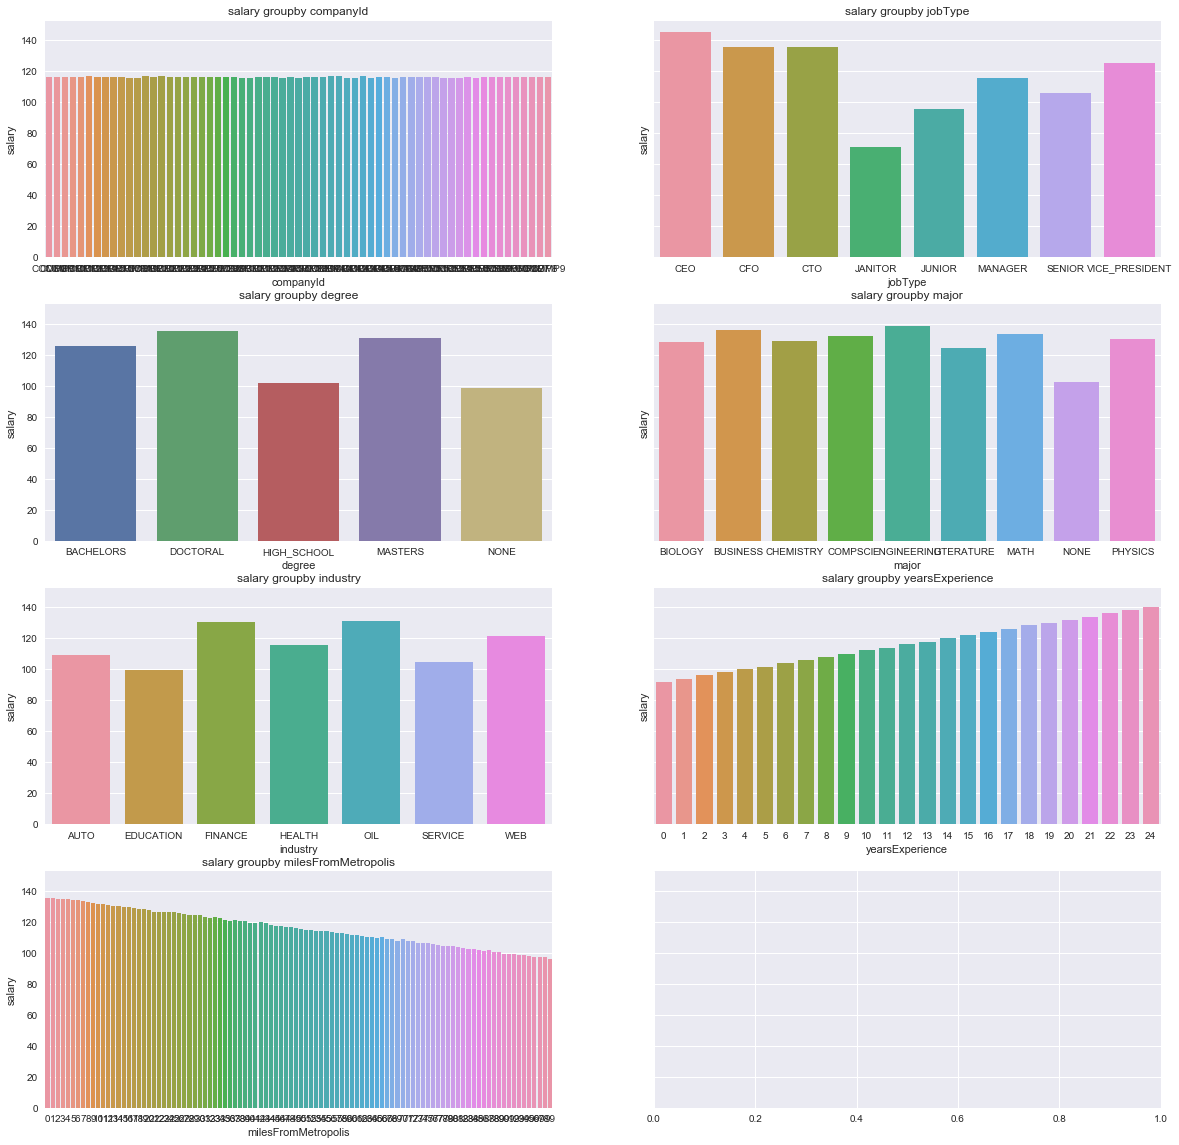

In [164]:
fig, ax= plt.subplots(nrows=4, ncols=2, figsize=(20, 20), sharey=True)
ax = ax.reshape(1,8)[0]
for i, col in enumerate(['companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis']):
    salary_goupby_col = train.groupby([col]).salary.mean()
    sns.barplot(x=salary_goupby_col.index, y=salary_goupby_col, ax=ax[i]).set_title('salary groupby ' + col)

Looks like yearsExperience is positively correlated with salary, while milesFromMetropolis is negatively correlated with salary.   
All categorical variables have same influence on salary except for companyId.

Here is the correlation heatmap of numerical variables:

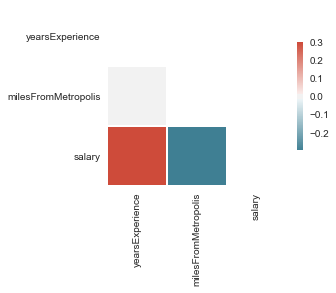

In [165]:
sns.set_style("white")
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(4,4))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 16, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

This varifies what we obesere in previous bar plots.

Let's check the test_features dataset, to see whether there are some unknown categories or extrapolation problem:

In [166]:
[companyId for companyId in test_features.companyId.unique() if companyId not in train.companyId.unique()]

[]

In [167]:
[jobType for jobType in test_features.jobType.unique() if jobType not in train.jobType.unique()]

[]

In [168]:
[major for major in test_features.major.unique() if major not in train.major.unique()]

[]

In [169]:
[industry for industry in test_features.industry.unique() if industry not in train.industry.unique()]

[]

In [170]:
[yearsExperience for yearsExperience in test_features.yearsExperience.unique() if yearsExperience not in train.yearsExperience.unique()]

[]

In [171]:
[milesFromMetropolis for milesFromMetropolis in test_features.milesFromMetropolis.unique() if milesFromMetropolis not in train.milesFromMetropolis.unique()]

[]

So we don't nedd to deal with unknown categories or extrapolation problem in test_features.

# Feature Engineering

Let's randomly split the data into training set (0.8) and validation set (0.1) and test set (0.1), since the data is large enough:

In [172]:
split_inedx = np.random.choice(3, train.shape[0], p=[0.8, 0.1, 0.1])

In [173]:
new_train = train[split_inedx==0].reset_index(drop=True)
new_val = train[split_inedx==1].reset_index(drop=True)
new_test = train[split_inedx==2].reset_index(drop=True)

In [174]:
new_train.shape, new_val.shape, new_test.shape

((800119, 9), (99731, 9), (100145, 9))

Let's convert companyId into numerical values:

In [175]:
# label encoding
def label_encoding_col(col):
    """
    Encodes a pandas column with continous ids. 
    """
    uniq = col.unique()
    name2idx = {o:i for i,o in enumerate(uniq)}
    return name2idx, np.array([name2idx[x] for x in col]), len(uniq)

In [176]:
companyId_to_index, new_train['companyId'], num_companyId = label_encoding_col(new_train['companyId'])

In [177]:
new_val['companyId'] = new_val['companyId'].map(companyId_to_index)
new_test['companyId'] = new_test['companyId'].map(companyId_to_index)

We can also convert some categorical variables into numerical values using mean encoding (has sorting quality, can help ensemble Tree model such as Random Forest and XGBoost) rather than label encoding on jobType, degree, major, and industry:

In [178]:
from sklearn.model_selection import KFold
def target_encoding(train, col = "jobType"):
    """ 
    Computes regularize mean encoding on training data.  
    """
    
    kf = KFold(n_splits=5)
    X = train.copy()
    X[col + "_mean_enc"] = 0
    for train_index, val_index in kf.split(X):
        # get training statistics in X, and change in train
        mean_col = X.loc[train_index].groupby(col).salary.mean()
        train.loc[val_index, col + "_mean_enc"] = train[col].map(mean_col)
    # fill na
    global_mean = X.salary.mean()
    train[col + "_mean_enc"].fillna(global_mean, inplace=True)

def mean_encoding_test(test, train, col = "jobType"):
    """ 
    Computes target enconding for test data.
    """
    mean_col = train.groupby(col).salary.mean()
    test[col + "_mean_enc"] = test[col].map(mean_col)
    # fill na
    global_mean = train.salary.mean()
    test[col + "_mean_enc"].fillna(global_mean, inplace=True)

In [179]:
target_encoding(new_train, col = "jobType")
mean_encoding_test(new_val, new_train, col = "jobType")
mean_encoding_test(new_test, new_train, col = "jobType")

In [180]:
target_encoding(new_train, col = "degree")
mean_encoding_test(new_val, new_train, col = "degree")
mean_encoding_test(new_test, new_train, col = "degree")

In [181]:
target_encoding(new_train, col = "major")
mean_encoding_test(new_val, new_train, col = "major")
mean_encoding_test(new_test, new_train, col = "major")

In [182]:
target_encoding(new_train, col = "industry")
mean_encoding_test(new_val, new_train, col = "industry")
mean_encoding_test(new_test, new_train, col = "industry")

In [183]:
new_train.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,jobType_mean_enc,degree_mean_enc,major_mean_enc,industry_mean_enc
0,JOB1362684407688,0,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101,145.338783,101.919172,102.573933,121.707264
1,JOB1362684407689,1,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137,125.396191,135.478282,130.440985,115.774427
2,JOB1362684407690,2,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142,115.443570,135.478282,128.937646,109.419574
3,JOB1362684407691,3,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163,125.396191,125.443816,130.440985,130.644209
4,JOB1362684407692,4,MANAGER,DOCTORAL,COMPSCI,FINANCE,2,31,113,115.443570,135.478282,132.128548,130.644209


In [184]:
new_test.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,jobType_mean_enc,degree_mean_enc,major_mean_enc,industry_mean_enc
0,JOB1362684407708,5,JUNIOR,NONE,NONE,AUTO,14,62,68,95.332486,98.173893,102.569156,109.422435
1,JOB1362684407732,24,VICE_PRESIDENT,MASTERS,LITERATURE,OIL,0,76,112,125.386260,130.456661,124.429459,131.025324
2,JOB1362684407739,56,JUNIOR,MASTERS,BIOLOGY,FINANCE,11,72,88,95.332486,130.456661,127.756811,130.662140
3,JOB1362684407740,39,MANAGER,DOCTORAL,ENGINEERING,WEB,24,58,193,115.384606,135.460702,138.487446,121.665454
4,JOB1362684407741,13,JANITOR,HIGH_SCHOOL,NONE,AUTO,9,4,91,70.808244,101.900083,102.569156,109.422435


# Model Building

Let's first build a Random Forest model, and perform feature selection based on feature importance.  
Since it Random Forest is ensemble tree model, we don't need to scale the data.

In [185]:
from sklearn.ensemble import forest
def set_rf_samples(n):
    """ 
    Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

In [186]:
set_rf_samples(50000)
rf_int = RandomForestRegressor(n_estimators=10, criterion='mse', max_depth=10, min_samples_split=5,
                          min_samples_leaf=10, max_features=0.5, n_jobs=-1)

In [187]:
keep = ['companyId', 'yearsExperience', 'milesFromMetropolis', 'jobType_mean_enc',
       'degree_mean_enc', 'major_mean_enc', 'industry_mean_enc' ]

In [188]:
rf_int.fit(new_train[keep], new_train['salary'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [189]:
import math
def rmse(y_true, y_pred):
#    return np.power(np.mean(np.power(y_true - y_pred, 2)), 0.5)
    return math.sqrt(((y_true-y_pred)**2).mean())

In [190]:
train_rmse = rmse(new_train['salary'], rf_int.predict(new_train[keep]))
val_rmse = rmse(new_val['salary'], rf_int.predict(new_val[keep]))
print('Traing RMSE: ', train_rmse)
print('Validation RMSE: ', val_rmse)

Traing RMSE:  19.601672055489036
Validation RMSE:  19.662648629235637


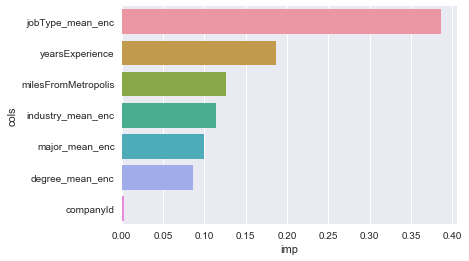

In [214]:
def plot_feat_importance(model, df):
    """
    Plot feature importance of input trained model.
    """
    fi = pd.DataFrame({'cols':df.columns, 'imp':model.feature_importances_}
                       ).sort_values('imp', ascending=False)
    sns.set(color_codes=True)
    sns.barplot(y = fi['cols'], x = fi['imp'])
    return fi
fi = plot_feat_importance(rf_int, new_train[keep])

Let's select features with feature importance >= 0.01 (discard variable $companyId$):

In [216]:
keep_final = fi[fi['imp']>=0.01].cols

In [193]:
m = RandomForestRegressor(n_estimators=10, criterion='mse', max_depth=10, min_samples_split=5,
                          min_samples_leaf=10, max_features=0.5, n_jobs=-1, random_state=50)
m.fit(new_train[keep_final], new_train['salary'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=50, verbose=0, warm_start=False)

In [194]:
train_rmse = rmse(new_train['salary'], m.predict(new_train[keep_final]))
val_rmse = rmse(new_val['salary'], m.predict(new_val[keep_final]))
print('Traing RMSE: ', train_rmse)
print('Validation RMSE: ', val_rmse)

Traing RMSE:  19.480644168423165
Validation RMSE:  19.549366861034297


As we can see, the RMSE of both training set and validation set is even bettern after we delete companyId, and here is the feature importance of our new model:

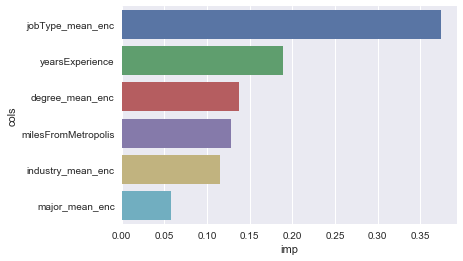

In [195]:
fi = plot_feat_importance(m, new_train[keep_final])

Let's tune hyperparameters to achieve the best RMSE on validation set:

In [196]:
validation_rmse_rf = pd.DataFrame({'val_rmse':np.zeros(90), 'train_rmse':np.zeros(90), 
                                   'max_depth': np.zeros(90), 
                                   'min_samples_leaf': np.zeros(90), 'max_features': np.zeros(90)})

In [197]:
i = 0
for max_depth in [6, 8, 10]:
    for min_samples_leaf in range(5,15):
        for max_features in [0.5, 'sqrt', 'log2']:
            m = RandomForestRegressor(n_estimators=30, criterion='mse', max_depth=max_depth, 
                                      min_samples_split=20, min_samples_leaf=min_samples_leaf, 
                                      max_features=max_features, n_jobs=-1, random_state=40)
            m.fit(new_train[keep_final], new_train['salary'])
            train_rmse = rmse(new_train['salary'], m.predict(new_train[keep_final]))
            val_rmse = rmse(new_val['salary'], m.predict(new_val[keep_final]))
            validation_rmse_rf.iloc[i] = val_rmse, train_rmse, max_depth, min_samples_leaf, max_features
            i += 1

In [198]:
validation_rmse_rf.columns = ['val_rmse', 'train_rmse', 'max_depth', 'min_samples_leaf', 
                              'max_features']

In [199]:
validation_rmse_rf.sort_values(['val_rmse']).head()

,val_rmse,train_rmse,max_depth,min_samples_leaf,max_features
81,19.425732,19.374007,10.0,12.0,0.5
78,19.433602,19.369333,10.0,11.0,0.5
75,19.437754,19.381439,10.0,10.0,0.5
87,19.438569,19.384172,10.0,14.0,0.5
69,19.442441,19.379773,10.0,8.0,0.5


In [200]:
m = RandomForestRegressor(n_estimators=30, criterion='mse', max_depth=10, 
                  min_samples_split=20, min_samples_leaf=9, 
                  max_features=0.5, n_jobs=-1, random_state=40)
m.fit(new_train[keep_final], new_train['salary'])
train_rmse = rmse(new_train['salary'], m.predict(new_train[keep_final]))
val_rmse = rmse(new_val['salary'], m.predict(new_val[keep_final]))

In [201]:
train_rmse, val_rmse

(19.38612549277942, 19.44266632703868)

Let's also train an XGBoost model so that we can use **averaging predictions of multiple models to reduce overfit**:

In [202]:
validation_rmse_xgb = pd.DataFrame({'val_rmse':np.zeros(27), 'train_rmse':np.zeros(27), 
                                    'max_depth': np.zeros(27), 'subsample': np.zeros(27), 
                                    'colsample_bytree': np.zeros(27)})

In [203]:
i = 0
for max_depth in [6, 8, 10]:
    for subsample in [0.6, 0.7, 0.8]:
        for colsample_bylevel in [0.6, 0.7, 0.8]:
            m = xgb.XGBRegressor(n_estimators=30, learning_rate=0.1, max_depth=max_depth, subsample=subsample, 
                                 colsample_bylevel=colsample_bylevel, n_jobs=-1, random_state=40)
            m.fit(new_train[keep_final], new_train['salary'])
            train_rmse = rmse(new_train['salary'], m.predict(new_train[keep_final]))
            val_rmse = rmse(new_val['salary'], m.predict(new_val[keep_final]))
            validation_rmse_xgb.iloc[i] = val_rmse, train_rmse, max_depth, subsample, colsample_bylevel
            i += 1

In [204]:
validation_rmse_xgb.columns = ['val_rmse', 'train_rmse', 'max_depth', 'subsample', 'colsample_bylevel']

In [205]:
validation_rmse_xgb.sort_values(['val_rmse']).head()

,val_rmse,train_rmse,max_depth,subsample,colsample_bylevel
23,19.708315,19.449637,10.0,0.7,0.8
22,19.708315,19.449637,10.0,0.7,0.7
20,19.713338,19.460563,10.0,0.6,0.8
19,19.713338,19.460563,10.0,0.6,0.7
18,19.724501,19.486054,10.0,0.6,0.6


Let's select the best 2 models from Random Forest (weight 0.4, 0.3) and the best model from XGBoost (weight 0.3), merge train and validation set to whole training data, average their predictions with weight, and use test data to see the performance:

In [206]:
final_train = new_test = train[split_inedx!=2].reset_index(drop=True)
target_encoding(final_train, col = "jobType")
mean_encoding_test(new_test, final_train, col = "jobType")
target_encoding(final_train, col = "degree")
mean_encoding_test(new_test, final_train, col = "degree")
target_encoding(final_train, col = "industry")
mean_encoding_test(new_test, final_train, col = "industry")
target_encoding(final_train, col = "major")
mean_encoding_test(new_test, final_train, col = "major")

In [207]:
bst1 = RandomForestRegressor(n_estimators=30, criterion='mse', max_depth=10, 
                  min_samples_split=20, min_samples_leaf=11, 
                  max_features=0.5, n_jobs=-1, random_state=40)
bst1.fit(final_train[keep_final], final_train['salary'])

bst2 = RandomForestRegressor(n_estimators=30, criterion='mse', max_depth=10, 
                  min_samples_split=20, min_samples_leaf=10, 
                  max_features=0.5, n_jobs=-1, random_state=40)
bst2.fit(final_train[keep_final], final_train['salary'])

bst3 = xgb.XGBRegressor(n_estimators=30, learning_rate=0.1, max_depth=10, subsample=0.7, 
                                 colsample_bylevel=0.8, n_jobs=-1, random_state=40)
bst3.fit(final_train[keep_final], final_train['salary'])

avg_train_pred = (0.4*bst1.predict(final_train[keep_final]) + 0.3*bst2.predict(final_train[keep_final]) +
                     0.3*bst3.predict(final_train[keep_final]))
train_rmse = rmse(final_train['salary'], avg_train_pred)
print('Train RMSE: ', train_rmse)

avg_test_pred = (0.4*bst1.predict(new_test[keep_final]) + 0.3*bst2.predict(new_test[keep_final]) +
                     0.3*bst3.predict(new_test[keep_final]))
test_rmse = rmse(new_test['salary'], avg_test_pred)
print('Test RMSE: ', test_rmse)

Train RMSE:  19.19550445410573
Test RMSE:  19.19550445410573


Let's use the weighted ensemble model to predict the real test data (test_features_2013-03-07.csv):

In [208]:
mean_encoding_test(test_gfeatures, final_train, col = "jobType")
mean_encoding_test(test_features, final_train, col = "degree")
mean_encoding_test(test_features, final_train, col = "industry")
mean_encoding_test(test_features, final_train, col = "major")

In [209]:
real_test_pred = 0.4*bst1.predict(test_features[keep_final]) + 0.3*bst2.predict(test_features[keep_final]) +\
                 0.3*bst3.predict(test_features[keep_final])

In [211]:
test_salaries = pd.DataFrame({'jobId': test_features['jobId'], 'salary': real_test_pred})

In [221]:
test_salaries.head()

,jobId,salary
0,JOB1362685407687,109.163468
1,JOB1362685407688,95.777788
2,JOB1362685407689,171.489965
3,JOB1362685407690,105.996162
4,JOB1362685407691,111.312048


In [222]:
test_salaries.to_csv('test_salaries.csv')